# Уравнения акустики
$\def\d{\partial}$ 
$\def\s{\sigma}$ 
Задана система уравнений, описывающая распространение акустических волн в несжимаемой среде:
    
$\cfrac{\d \vec{w}}{\d t} + A\cfrac{\d \vec{w}}{\d x} = 0,\ x \in [-L, L],\ t \in [0, T]$

$\vec{w} = \vec{w}(x,t) = \begin{pmatrix} u(x,t) \\ p(x,t) \end{pmatrix},\ A = \begin{pmatrix} 0 & \rho^{-1} \\ \rho c^2 & 0 \end{pmatrix}$

где $u$ - скорость частиц среды, $p$ - давление, $\rho$ - плотность среды, $c$ - скорость звука в ней

Также исходная система может быть переписана с использованием инвариантов Римана. Матрица $A$ имеет следующие левые собственные векторы:

$\lambda_1 = -c\ \leftrightarrow\ \vec{s} = (-c\rho,\ 1)^T$

$\lambda_2 = c\ \leftrightarrow\ \vec{r} = (c\rho,\ 1)^T$

Тогда вводя новые переменные, инварианты Римана:

$\begin{cases} R = \vec{r}^T\vec{w} = p + c\rho u\\ S = \vec{s}^T\vec{w} = p - c\rho u \end{cases}  \leftrightarrow \begin{cases} u = \cfrac{R - S}{2\rho c}\\ p = \cfrac{R + S}{2}\end{cases}$

cистема принимает вид (при условии постоянности $\rho$ и $c$):

$\left\{ \begin{aligned} \cfrac{\d R}{\d t} + c\cfrac{\d R}{\d x} = 0 \\ \cfrac{\d S}{\d t} - c\cfrac{\d S}{\d x} = 0 \end{aligned} \right. \Leftrightarrow \begin{cases} R (x, t) = R(x - ct)\\ S(x,t) = S(x + ct) \end{cases}$

# Задача о распаде разрыва

Начальные условия:

$\vec{w}(x,0) = \begin{cases} \vec{w_1}, x < 0\\ \vec{w_2}, x > 0 \end{cases}$

$\rho(x,0) = \begin{cases} \rho_1, x < 0\\ \rho_2, x > 0 \end{cases}$

$c(x,0) = \begin{cases} c_1, x < 0\\ c_2, x > 0 \end{cases}$

Условие сшивки на границе раздела сред:

$\vec{w}(-0, t) = \vec{w}(+0, t),\ t > 0$

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

########INPUT#######

rho1 = 1.5 # плотность среды
rho2 = 2.5
c1 = 1. # скорость звука в среде
c2 = 2.
L = 5. # полуширина расчётной области
T = 2.
u1, u2 = 1, 2
p1, p2 = 1.5, 5
w1 = np.matrix([u1, p1]).T
w2 = np.matrix([u2, p2]).T

####################

# Аналитическое решение
Данная задача имеет следующее точное аналитическое решение:
    
$\vec{w}(x,t) = \begin{cases} \vec{w_1},\ x < -c_1 t\\ \cfrac{1}{c_1\rho_1 + c_2\rho_2} \left(\begin{pmatrix} 1 \\ c_2\rho_2 \end{pmatrix} \begin{pmatrix} c_1\rho_1 & 1\end{pmatrix}\vec{w_1} + \begin{pmatrix} -1 \\ c_1\rho_1 \end{pmatrix} \begin{pmatrix} -c_2\rho_2 & 1\end{pmatrix}\vec{w_2} \right),\ -c_1 t \le x \le c_2 t\\ \vec{w_2},\ x > c_2 t \end{cases}$

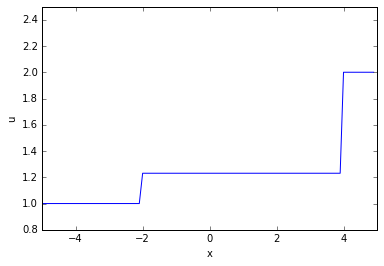

In [2]:
def sol_at_point(x, t):
        w3 = 1 / (c1*rho1 + c2 * rho2) \
            * ((np.matrix([c1*rho1, 1]) * w1).item(0) * np.matrix([1, c2*rho2]).T\
           + (np.matrix([-c2*rho2, 1])* w2).item(0) * np.matrix([-1, c1*rho1]).T)
        if (x < -c1 * t):
            return w1
        elif (x > c2 * t): 
            return w2
        else: 
            return w3
        
def exact_solution (M1, h1, M2, h2, t):
    
    w = [sol_at_point((-M1 + m) * h1, t) for m in range(M1 + 1)]
    w.extend([sol_at_point((m + 1) * h2, t) for m in range(M2)])
    u = [w[m].item(0) for m in range(M1 + M2 + 1)]
    p = [w[m].item(1) for m in range(M1 + M2 + 1)]
    
    return u, p

M1 = 50 # число шагов по координате в полупространстве
h1 = L / M1 # шаг по координате
M2 = 50 # число шагов по координате в полупространстве
h2 = L / M2 # шаг по координате
x0 = -L #начало расчётного отрезка
u, p = exact_solution(M1, h1, M2, h2, T)
x = [((-M1 + m) * h1) for m in range(M1 + 1)]
x.extend([(m * h2) for m in range(M2)])
plt.plot(x, u)
plt.axis([-L, L, 0.8, 2.5])
plt.xlabel('x')
plt.ylabel("u")
plt.show()

Теперь будем решать исходную задачу разными вычислительными методами.

Для этого в первую очередь надо перейти с задачи Коши на неограниченной области к смешанной задаче на отрезке.

Для этого необходимо добавить граничные условия, приносимые характеристиками из бесконечности, в рассматриваемом случае эти условия будут иметь вид:

1) $\vec{r}_1^T \vec{w}(-L, t) = \vec{r}_1 \vec{w}_1$, где $\vec{r}_1 = \begin{pmatrix} c_1\rho_1 & 1\end{pmatrix}$

2) $\vec{s}_2^T \vec{w}(L, t) = \vec{s}_2 \vec{w}_2$, где $\vec{s}_2 = \begin{pmatrix} -c_2\rho_2 & 1\end{pmatrix}$

# Схема Лакса-Вендрофа
Воспользуемся следующей расчётной схемой:

$\vec{w}^{n+1}_{m} = \vec{w}^{n}_{m} - \cfrac{\tau}{2h}A(\vec{w}^{n}_{m+1} - \vec{w}^{n}_{m-1}) + \cfrac{\tau^2}{2h^2}A^2(\vec{w}^{n}_{m+1} - 2\vec{w}^{n}_{m} + \vec{w}^{n}_{m-1})$

Для этой схемы нужно также провести аппроксимацию граничных условий, но в этой работе мы не будем этого делать, а вместо этого, будем считать, что нам известны точные значения $\vec{w}(\pm L, t)$, которые возьмём из аналитического решения. В силу непрерывности решения на границе раздела сред, будем считать $\vec{w}^n_{\frac{M}{2}+0} = \vec{w}^n_{\frac{M}{2}-0} = \cfrac{\vec{w}^n_{\frac{M}{2}+1} + \vec{w}^n_{\frac{M}{2}-1}}{2}$ $\forall\ n > 0$

(1.0, 1.0)


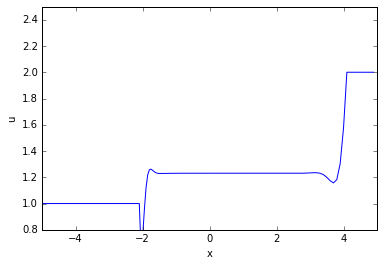

In [27]:
def w0(x): # = w(x,0) = (u(x, 0), p(x, 0))^T - начальное условие
    if (x > 0):
        return w2
    else:
        return w1

def Lax_Wendroff_method1(M1, h1, M2, h2, N, tau):
    
    sigma1 = tau / h1
    sigma2 = tau / h2
    A1 = np.matrix([[0,1/rho1], [rho1 * c1**2, 0]]) # матрица акустической системы левого полупространства
    AA1 = A1**2
    A2 = np.matrix([[0,1/rho2], [rho2 * c2**2, 0]]) # матрица акустической системы правого полупространства
    AA2 = A2**2
    
    ####initialization####    
    
    def init():
        w = [[],[]] # w[I][m] есть w в точке mh, I - индикатор временого слоя
        for m in range(M1 + 1):
            w[0].append(w0((-M1 + m)*h1))
            w[1].append(w0((-M1 + m)*h1))
        for m in range(1, M2+1):
            w[0].append(w0(m*h2))
            w[1].append(w0(m*h2))
        w[0][M1] = (w[0][M1 - 1] + w[0][M1 + 1]) / 2
        #w[0][M1] = sol_at_point(0, tau)
        return w
    
    w = init()

    ####endinit#####                
    
    for n in range(1, N + 1):

        prev = (n-1)%2
        cur = n%2

        for m in range(1, M1):
            w[cur][m] = \
                w[prev][m]\
                - sigma1 / 2 * A1 * (w[prev][m+1] - w[prev][m-1]) \
                + sigma1**2 / 2 * AA1 * (w[prev][m-1] - 2*w[prev][m] + w[prev][m+1])
        for m in range(1, M2):
            r = m + M1
            w[cur][r] = \
                w[prev][r]\
                - sigma2 / 2 * A2 * (w[prev][r+1] - w[prev][r-1]) \
                + sigma2**2 / 2 * AA2 * (w[prev][r-1] - 2*w[prev][r] + w[prev][r+1]) 
        w[cur][M1] = (w[cur][M1 - 1] + w[cur][M1 + 1]) / 2

        w[cur][0] = sol_at_point(-L, n * tau)
        w[cur][M1 + M2] = sol_at_point(L, n * tau)
        
    cur = N%2
    u = [w[cur][m].item(0) for m in range(M1 + M2 + 1)]
    p = [w[cur][m].item(1) for m in range(M1 + M2 + 1)]
    
    return u, p

tau = 0.05
M1 = 100
M2 = 50
h1 = L / M1
h2 = L / M2
sigma1 = c1 * tau / h1
sigma2 = c2 * tau / h2
print(sigma1, sigma2)
N = int(round(T / tau)) + 1
u, p = Lax_Wendroff_method1(M1, h1, M2, h2, N, tau)
x = [((-M1 + m) * h1) for m in range(M1 + 1)]
x.extend([(m * h2) for m in range(M2)])
plt.plot(x, u)
plt.axis([-L, L, 0.8, 2.5])
plt.xlabel('x')
plt.ylabel("u")
plt.show()

Теперь будем считать, что мы также знаем точное значение в нуле

(1.0, 1.0)


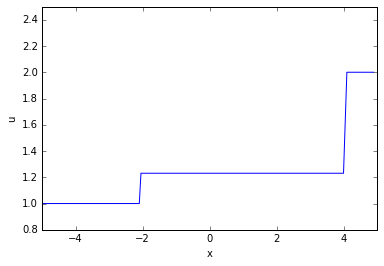

In [19]:
def w0(x): # = w(x,0) = (u(x, 0), p(x, 0))^T - начальное условие
    if (x > 0):
        return w2
    else:
        return w1

def Lax_Wendroff_method2(M1, h1, M2, h2, N, tau):
    
    sigma1 = tau / h1
    sigma2 = tau / h2
    A1 = np.matrix([[0,1/rho1], [rho1 * c1**2, 0]]) # матрица акустической системы левого полупространства
    AA1 = A1**2
    A2 = np.matrix([[0,1/rho2], [rho2 * c2**2, 0]]) # матрица акустической системы правого полупространства
    AA2 = A2**2
    
    ####initialization####    
    
    def init():
        w = [[],[]] # w[I][m] есть w в точке mh, I - индикатор временого слоя
        for m in range(M1 + 1):
            w[0].append(w0((-M1 + m)*h1))
            w[1].append(w0((-M1 + m)*h1))
        for m in range(1, M2 + 1):
            w[0].append(w0(m*h2))
            w[1].append(w0(m*h2))
        w[0][M1] = sol_at_point(0, tau)
        return w
    
    w = init()

    ####endinit#####                
    
    for n in range(1, N + 1):

        prev = (n-1)%2
        cur = n%2

        for m in range(1, M1):
            w[cur][m] = \
                w[prev][m]\
                - sigma1 / 2 * A1 * (w[prev][m+1] - w[prev][m-1]) \
                + sigma1**2 / 2 * AA1 * (w[prev][m-1] - 2*w[prev][m] + w[prev][m+1])
        for m in range(1, M2):
            r = m + M1
            w[cur][r] = \
                w[prev][r]\
                - sigma2 / 2 * A2 * (w[prev][r+1] - w[prev][r-1]) \
                + sigma2**2 / 2 * AA2 * (w[prev][r-1] - 2*w[prev][r] + w[prev][r+1])

        w[cur][0] = sol_at_point(-L, n * tau)
        w[cur][M1] = sol_at_point(0, n * tau)
        w[cur][M1 + M2] = sol_at_point(L, n * tau)
        
    cur = N%2
    u = [w[cur][m].item(0) for m in range(M1 + M2 +1)]
    p = [w[cur][m].item(1) for m in range(M1 + M2 +1)]
    
    return u, p

tau = 0.05
M1 = 100
M2 = 50
h1 = L / M1
h2 = L / M2
sigma1 = c1 * tau / h1
sigma2 = c2 * tau / h2
print(sigma1, sigma2)
N = int(round(T / tau)) + 1
u, p = Lax_Wendroff_method2(M1, h1, M2, h2, N, tau)
x = [((-M1 + m) * h1) for m in range(M1 + 1)]
x.extend([(m * h2) for m in range(M2)])
plt.plot(x, u)
plt.axis([-L, L, 0.8, 2.5])
plt.xlabel('x')
plt.ylabel("u")
plt.show()

Как видим, осцилляции в областях бесконечных градиентов остались (хотя и немного ослабли)

# Методы характеристик

Теперь рассмотрим методы описывающие поведение характеристик.

$\left\{ \begin{aligned} \cfrac{\d R}{\d t} + c\cfrac{\d R}{\d x} = 0 \\ \cfrac{\d S}{\d t} - c\cfrac{\d S}{\d x} = 0 \end{aligned} \right.$

Здесь важно учесть преобразование инвариантов при переходе через границу двух сред

Для удобства, через $R_1$, $S_1$ и $R_2$, $S_2$ будем обозначать инварианты в левой и правой областях соответсвенно.

Граничные условия: 

1)$R_1(-L, t) = (\vec{r}_1, \vec{w}_1)$

1)$S_2(L, t) = (\vec{s}_2, \vec{w}_2)$

In [5]:
###инициализация параметров для методов характеристик###
r1 = np.matrix([c1 * rho1, 1]).T
s1 = np.matrix([-c1 * rho1, 1]).T
r2 = np.matrix([c2 * rho2, 1]).T
s2 = np.matrix([-c2 * rho2, 1]).T
left_cond = (r1.T * w1).item(0)
right_cond = (s2.T * w2).item(0)

def convert(R1, S2, M1): #преобразование характеристик при переходе через границу раздела сред
    B = la.inv(np.matrix([[c1 * rho1, 1],[-c2 * rho2, 1]]))
    w = B * np.matrix([R1[M1], S2[0]]).T
    R2_0 = (r2.T * w).item(0)
    S1_M1 = (s1.T * w).item(0)
    return R2_0, S1_M1

def get_u_p(R, S, rho, c, M): #переход от характеристик к переменным задачи
    u = [(R[m] - S[m])/(2*rho*c) for m in range(M+1)] # скорость движения
    p = [(R[m] + S[m])/2 for m in range(M+1)] # давление
    return u, p

def init(M1, M2): #инициализация
    R1 = [[]] # R[I][m] - характеристика, I индикатор момента времени, m - координата
    S1 = [[]] 
    R2 = [[]]
    S2 = [[]]

    for m in range(M1 + 1):
        R1[0].append((r1.T * w1).item(0))
        S1[0].append((s1.T * w1).item(0))
    for m in range(M2 + 1):
        R2[0].append((r2.T * w2).item(0))
        S2[0].append((s2.T * w2).item(0))

    R1.append(list(range(M1 + 1)))
    S1.append(list(range(M1 + 1)))
    R2.append(list(range(M2 + 1)))
    S2.append(list(range(M2 + 1)))
        
    return R1, S1, R2, S2

# Схема Куранта-Изаксона-Риса

Проведём вычисления, используя следующую схему:
 
$\begin{cases}
R^{n+1}_m = R^n_m - \s (R^n_m - R^n_{m - 1}) \\
S^{n+1}_m = S^n_m + \s (S^n_{m+1} - S^n_m)
\end{cases}$

(1.0, 1.0)


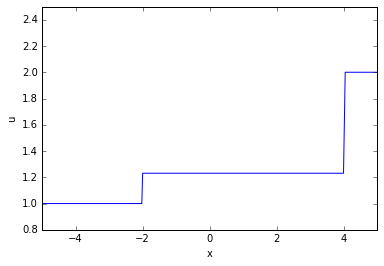

In [6]:
def Courant_Isaacson_Rees_method(M1, h1, M2, h2, N, tau):
    sigma1 = c1 * tau / h1
    sigma2 = c2 * tau / h2
    R1, S1, R2, S2 = init(M1, M2)

    for n in range(1,N+1):

        prev = (n-1)%2
        cur = n%2

        for m in range(1, M1+1):
            R1[cur][m] = R1[prev][m] - sigma1 * (R1[prev][m] - R1[prev][m-1])
            S1[cur][m - 1] = S1[prev][m - 1] - sigma1 * (S1[prev][m-1] - S1[prev][m])
        for m in range(1, M2+1):
            R2[cur][m] = R2[prev][m] - sigma2 * (R2[prev][m] - R2[prev][m-1])
            S2[cur][m - 1] = S2[prev][m - 1] - sigma2 * (S2[prev][m-1] - S2[prev][m])
        R1[cur][0] = left_cond
        S2[cur][M2] = right_cond
        R2[cur][0], S1[cur][M1] = convert(R1[cur], S2[cur], M1)

    cur = N % 2
    u1, p1 = get_u_p(R1[cur], S1[cur], rho1, c1, M1)
    u2, p2 = get_u_p(R2[cur], S2[cur], rho2, c2, M2)
    u1.extend(u2)
    p1.extend(p2)
    u = u1
    p = p1
    return u, p 

tau = 0.025
N = int(round(T / tau)) + 1
M1 = 200 # число шагов по координате в левом полупространстве
h1 = L / M1 # шаг по координате
M2 = 100 # число шагов по координате в левом полупространстве
h2 = L / M2 # шаг по координате
sigma1 = c1 * tau / h1
sigma2 = c2 * tau / h2
print(sigma1, sigma2)
u, p = Courant_Isaacson_Rees_method(M1, h1, M2, h2, N, tau)

x = [((-M1 + m) * h1) for m in range(M1 + 1)]
x.extend([( m * h2) for m in range(M2 + 1)])
plt.plot(x, u)
plt.axis([-L, L, 0.8, 2.5])
plt.xlabel('x')
plt.ylabel("u")
plt.show()

Получается удовлетворительный результат при $\sigma_1, \sigma_2$, близких к единице, осцилляции не возникают при $\sigma_1, \sigma_2 \le 1$ 

# Схема Роу "Кабаре"

Теперь воспользуемся этой схемой
$\begin{cases}
R^{n+1}_{m} = R^{n}_{m} + R^{n - 1}_{m - 1} - R^{n}_{m - 1} - 2\s(R^{n}_{m} - R^{n}_{m-1}) \\
S^{n+1}_{m} = S^{n}_{m} + S^{n - 1}_{m + 1} - S^{n}_{m + 1} + 2\s(S^{n}_{m+1} - S^{n}_{m})   
\end{cases}$

(1.0, 1.0)


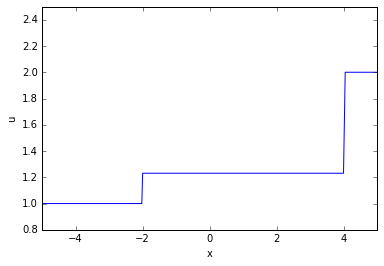

In [36]:
def CABARET_method(M1, h1, M2, h2, N, tau):
    sigma1 = c1 * tau / h1
    sigma2 = c2 * tau / h2
    
    def CABARET_init(M1, M2):
        R1, S1, R2, S2 = init(M1, M2)
        u, p = Courant_Isaacson_Rees_method(M1, h1, M2, h2, 1, tau)
        for m in range(M1 + 1):
            R1[1][m] = (r1.T * np.matrix([u[m], p[m]]).T).item(0)
            S1[1][m] = (s1.T * np.matrix([u[m], p[m]]).T).item(0)
        for m in range(M2 + 1):
            R2[1][m] = (r2.T * np.matrix([u[m + M1 + 1], p[m + M1 + 1]]).T).item(0)
            S2[1][m] = (s2.T * np.matrix([u[m + M1 + 1], p[m + M1 + 1]]).T).item(0)
        
        R1.append(list(range(M1 + 1)))
        S1.append(list(range(M1 + 1)))
        R2.append(list(range(M2 + 1)))
        S2.append(list(range(M2 + 1)))
        
        return R1, S1, R2, S2
    
    R1, S1, R2, S2 = CABARET_init(M1, M2)
    
    for n in range(2,N+1):
        prev_prev = (n-2)%3
        prev = (n-1)%3
        cur = n%3

        for m in range(1, M1 + 1):
            R1[cur][m] = \
                R1[prev][m] - R1[prev][m-1] + R1[prev_prev][m-1]\
                - 2 * sigma1 * (R1[prev][m] - R1[prev][m-1])
            S1[cur][m-1] = 2 * sigma1 * (S1[prev][m] - S1[prev][m-1])\
                + S1[prev][m-1] - S1[prev][m] + S1[prev_prev][m]
        for m in range(1, M2 + 1):
            R2[cur][m] = \
                R2[prev][m] - R2[prev][m-1] + R2[prev_prev][m-1]\
                - 2 * sigma2 * (R2[prev][m] - R2[prev][m-1])
            S2[cur][m - 1] = 2 * sigma2 * (S2[prev][m] - S2[prev][m-1])\
                + S2[prev][m-1] - S2[prev][m] + S2[prev_prev][m]
        R1[cur][0] = left_cond
        S2[cur][M2] = right_cond
        R2[cur][0], S1[cur][M1] = convert(R1[cur], S2[cur], M1)
    
    cur = N % 3
    u1, p1 = get_u_p(R1[cur], S1[cur], rho1, c1, M1)
    u2, p2 = get_u_p(R2[cur], S2[cur], rho2, c2, M2)
    u1.extend(u2)
    p1.extend(p2)
    u = u1
    p = p1
    return u, p 

tau = 0.025
N = int(round(T / tau)) + 1
M1 = 200 # число шагов по координате в левом полупространстве
h1 = L / M1 # шаг по координате
M2 = 100 # число шагов по координате в левом полупространстве
h2 = L / M2 # шаг по координате
sigma1 = c1 * tau / h1
sigma2 = c2 * tau / h2
print(sigma1, sigma2)
u, p = CABARET_method(M1, h1, M2, h2, N, tau)

x = [((-M1 + m) * h1) for m in range(M1 + 1)]
x.extend([m * h2 for m in range(M2 + 1)])
plt.plot(x, u)
plt.axis([-L, L, 0.8, 2.5])
plt.xlabel('x')
plt.ylabel("u")
plt.show()

Несложно видеть, что при $\sigma_1, \sigma_2\ \in\ \{0.5; 1\}$ получается точное решение, в то же время, при любых отклонениях от этих значения появляются осцилляции в областях высоких градиентов

# Метод Годунова решения квазилинейного уравнения

$\dfrac{\partial \vec{w}}{\partial t} + A \dfrac{\partial \vec{w}}{\partial x} = 0$, $A = \Omega^{-1} \Lambda \Omega$, где $\Omega = \begin{pmatrix} \vec{r}^T \\ \vec{s}^T \end{pmatrix}$ - матрица левых собственных векторов

$Q_m = min\ mod (\dfrac{u_{m+1} - u_m}{h}, \dfrac{u_{m} - u_{m - 1}}{h})$, где  $min\ mod(x, y) = 0.5(sign(x) + sign(y))\min(|x|, |y|)$

Предикатор: $\vec{w}^{n + 1/2}_m = \vec{w}^{n}_m - \frac{h}{2}A_m^n \vec{Q}^n_m$

Корректор: $\dfrac{\vec{w}^{n+1}_m - \vec{w}^{n}_{m}}{\tau} + (\Omega^{-1} \Lambda^- \Omega)_{m + \frac{1}{2}}^{n + \frac{1}{2}}\dfrac{\vec{w}^{n + \frac{1}{2}}_{m+1} - \frac{h}{2}\vec{Q}^n_{m+1} - \vec{w}^{n + \frac{1}{2}}_{m} - \frac{h}{2}\vec{Q}^n_{m}}{h} + (\Omega^{-1} \Lambda^+ \Omega)_{m - \frac{1}{2}}^{n + \frac{1}{2}}\dfrac{\vec{w}^{n + \frac{1}{2}}_{m} - \frac{h}{2}\vec{Q}^{n}_{m} - \vec{w}^{n + \frac{1}{2}}_{m - 1} - \frac{h}{2}\vec{Q}^n_{m-1}}{h} = 0$

Будем как и в случае Лакса-Вендрофа считать граничные точки известными.

In [8]:
# def Godunov_method(x0, M, h, N, tau):
#     A1 = np.matrix([[0,1/rho1], [rho1 * c1**2, 0]])
#     A2 = np.matrix([[0,1/rho2], [rho2 * c2**2, 0]])
#     L1_minus = np.matrix([[-c1/2,1/2 /rho1], [rho1 / 2 * c1**2, -c1/2]])
#     L1_plus = np.matrix([[c1/2,1/2 /rho1], [rho1 / 2 * c1**2, c1/2]])
#     L2_minus = np.matrix([[-c2/2,1/2 /rho2], [rho2 / 2 * c2**2, -c2/2]])
#     L2_plus = np.matrix([[c2/2,1/2 /rho2], [rho2 / 2 * c2**2, c2/2]])
#     def A(n, m):
#         if (x0 + m*h < 0):
#             return A1
#         else:
#             return A2
#     def L_plus(n, m):
#         if (x0 + m*h < 0):
#             return L1_plus
#         else:
#             return L2_plus
#     def L_minus(n, m):
#         if (x0 + m*h < 0):
#             return L1_minus
#         else:
#             return L2_minus
#     def sign(x):
#         return -min(-x, 0)
#     def min_mod(x, y):
#         return 0.5 * (sign(x) + sign(y)) * min(abs(x), abs(y))
#     def vec_min_mod(vec1, vec2):
#         Q = []
#         Q.append(min_mod(vec1.item(0), vec2.item(0)))
#         Q.append(min_mod(vec1.item(1), vec2.item(1)))
#         return np.matrix(Q).T
#     def Q(w, m):
#         return 1/h * vec_min_mod(w[m+1] - w[m], w[m] - w[m-1])
    
#     def init():
#         w = [[],[]] # w[I][m] есть w в точке mh, I - индикатор временого слоя
#         for m in range(M + 1):
#             w[0].append(w0(x0 + m*h))
#             w[1].append(w0(x0 + m*h))
#         w_ = list(range(M + 1))
#         return w, w_
    
#     w, w_ = init()
    
#     for n in range(1,N+1):
#         prev = (n-1)%2
#         cur = n%2
#         for m in range(2, M-1):
#             w_[m] = w[prev][m] + h/2 * A(n, m) * Q(w[prev], m)
#             w[cur][m] = w[prev][m] - tau/h * L_minus(n+1./2, m+1./2) * (w_[m+1] - h/2 * Q(w[prev], m + 1)\
#                         -w_[m] - h/2 * Q(w[prev], m)) - tau/h * L_plus(n+1./2, m-1./2) *\
#                         (w_[m] - h/2 * Q(w[prev], m)-w_[m-1] - h/2 * Q(w[prev], m-1)) 
#         w[cur][0] = sol_at_point(x0, n * tau)
#         w[cur][1] = sol_at_point(x0 + h, n * tau)
#         w[cur][M-1] = sol_at_point(x0 + (M-1)*h, n * tau)
#         w[cur][M] = sol_at_point(x0 + M*h, n * tau)
        
#     cur = N%2
#     u = [w[cur][m].item(0) for m in range(M + 1)]
#     p = [w[cur][m].item(1) for m in range(M + 1)]
    
#     return u, p

# tau = 0.05
# M = 100
# x0 = -L
# h = 2*L/M
# sigma1 = c1 * tau / h
# sigma2 = c2 * tau / h
# print(sigma1, sigma2)
# N =  0
# u, p = Godunov_method(x0, M, h, N, tau)
# x = [(x0 +  m * h) for m in range(M + 1)]
# plt.plot(x, u)
# plt.xlabel('x')
# plt.ylabel("u")
# plt.show()